## Environment Setup

In [ ]:
!mkdir -p ~/.aws && cp /content/drive/MyDrive/AWS/684947_admin ~/.aws/credentials
!chmod 600 ~/.aws/credentials
!pip install -qq awscli boto3
!aws sts get-caller-identity

## Real-Time Clickstream Anomaly Detection

![](https://user-images.githubusercontent.com/62965911/214810555-c3637a3c-7391-4076-892e-437e3219810c.png)

In [4]:
!aws cloudformation create-stack \
--stack-name KinesisLab \
--template-body file://kinesis_lab.yml \
--capabilities CAPABILITY_NAMED_IAM \
--parameters \
ParameterKey=Username,ParameterValue=sparsh \
ParameterKey=Password,ParameterValue= \
ParameterKey=email,ParameterValue=sprsag@gmail.com \
ParameterKey=SMS,ParameterValue=

{
    "StackId": "arn:aws:cloudformation:us-east-1:684199068947:stack/KinesisLab/4ce68140-6c7d-11ed-a678-0e9aa6818fbf"
}


Once your stack is deployed, click the Outputs tab to view more information:

- KinesisDataGeneratorUrl - This value is the Kinesis Data Generator (KDG) URL.
- RawBucketName - Name of bucket to store the raw data coming from KDG.
- ProcessedBucketName - Name of the bucket to store transformed data

### Confirm Subscriptions

You will receive an email and SMS from SNS, asking for you to confirm. Confirm the subscriptions.

### Set up the Amazon Kinesis Data Generator (KDG)

On the Outputs tab, notice the Kinesis Data Generator URL. Navigate to this URL to login into the Amazon Kinesis Data Generator (Amazon KDG).

Let’s test your Cognito user in the Kinesis Data Generator.

1. On the Outputs tab, click the KinesisDataGeneratorUrl. 
2. Sign in using the username and password you entered in the CloudFormation console. 
3. After you sign in, you should see the KDG console. You need to set up some templates to mimic the clickstream web payload. Note that your Kinesis Firehose has been deployed in the region where you deployed the CloudFormation stack.
4. Create the following templates but don’t click on Send Data yet, we will do that during the main lab. Copy the tab name highlight in bold letter and value as JSON string:
    - **Schema Discovery Payload** {"browseraction":"DiscoveryKinesisTest", "site": "yourwebsiteurl.domain.com"}
    - **Click Payload** {"browseraction":"Click", "site": "yourwebsiteurl.domain.com"}
    - **Impression Payload** {"browseraction":"Impression", "site": "yourwebsiteurl.domain.com"}

Your Amazon Kinesis Data Generator console should look similar to this example.

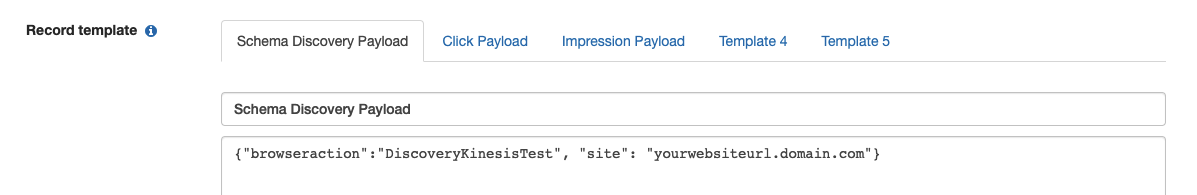

### Observe AWS Lambda Anomaly function

The CloudFormation template already deployed this Lambda function for you. Spend a few minutes to review the code and understand the actions that trigger the lambda:

1. In the console, navigate to AWS Lambda .
1. In the AWS Lambda navigation pane, select Functions **CSEBeconAnomalyResponse**. 
1. Click the function to scroll down to the code section. 
1. Go through the code in the Lambda code editor. Notice the TopicArn value is your recorded Email/SMS from the subscription step. Lambda will send message to this topic and send notifications.

### Real-Time Clickstream Anomaly Detection Kinesis Analytics

This guide helps you complete Real-Time Clickstream Anomaly Detection using Amazon Kinesis Data Analytics.

Analyzing web log traffic to gain insights that drive business decisions has historically been performed using batch processing. Although effective, this approach results in delayed responses to emerging trends and user activities. There are solutions that process data in real-time using streaming and micro-batching technologies, but they can be complex to set up and maintain. Amazon Kinesis Data Analytics is a managed service that makes it easy to identify and respond to changes in data behavior in real-time.

**Set up an Analytics Pipeline Application**

1. Make sure you are in the appropriate AWS region.
1. Navigate to the Amazon Kinesis Analytics applications SQL applications (legacy) console.
1. Click Create SQL application (legacy) to create an application.
1. On the Create legacy SQL application page, fill the fields as follows:
    - For Application name, enter **anomaly-detection-application**.
    - For Description, type a description for your application. 
1. Click Create legacy SQL application
1. On the application page, click Configure under Source tab. 
1. Under Source configuration make the following selections:
    - For Source, choose Kinesis Firehose delivery stream.
    - For Delivery stream, choose {stack-name}-FirehoseDeliveryStream-{some-random-string} from the "Kinesis Firehose delivery stream" dropdown
    - For Record preprocessing with AWS Lambda, leave it as Off.
    - For IAM role for reading source stream, select Choose from IAM roles that Kinesis Analytics can assume. Under the Service role dropdown, choose the role {stack-name}-CSEKinesisAnalyticsRole-{random string}. 
1. Do not click “Discover schema” yet. You have set up the Kinesis Data Analytics application to receive data from a Kinesis Data Firehose and to use an IAM role from the pre-lab. However, you need to start sending some data to the Kinesis Data Firehose before you click Discover schema in your application.
1. Navigate to the Amazon Kinesis Data Generator (KDG), which you setup earlier, start sending the Schema Discovery Payload at 1 record per second by clicking on the Send data button. Make sure to select the appropriate AWS region.  Now that your Kinesis Data Firehose is receiving data, you can continue configuring the Kinesis Data Analytics Application.
1. Go back to the Kinesis console, Now click Discover Schema. (Make sure your KDG is sending data to your Kinesis Data Firehose. If KDG was idle for more than 10-15 minutes or if the schema discovery fails, then refresh the KDG page and sign-in again.)
1. Click Save changes. Your Kinesis Data Analytics Application is created with an input stream.
1. Now, you can add some SQL queries to easily analyze the data that is being fed into the stream.
1. In the Real-time analytics section, click Configure to configure the SQL code.
1. Copy the contents of the following SQL and paste it into the SQL editor. 
    ```sql
    CREATE OR REPLACE STREAM "CLICKSTREAM" (
    "CLICKCOUNT" DOUBLE
    );

    CREATE OR REPLACE PUMP "CLICKPUMP" AS
    INSERT INTO "CLICKSTREAM" ("CLICKCOUNT")
    SELECT STREAM COUNT(*)
    FROM "SOURCE_SQL_STREAM_001"
    WHERE "browseraction" = 'Click'
    GROUP BY FLOOR(
    ("SOURCE_SQL_STREAM_001".ROWTIME - TIMESTAMP '1970-01-01 00:00:00')
        SECOND / 10 TO SECOND
    );

    CREATE OR REPLACE STREAM "IMPRESSIONSTREAM" (
    "IMPRESSIONCOUNT" DOUBLE
    );

    CREATE OR REPLACE PUMP "IMPRESSIONPUMP" AS
    INSERT INTO "IMPRESSIONSTREAM" ("IMPRESSIONCOUNT")
    SELECT STREAM COUNT(*)
    FROM "SOURCE_SQL_STREAM_001"
    WHERE "browseraction" = 'Impression'
    GROUP BY FLOOR(
    ("SOURCE_SQL_STREAM_001".ROWTIME - TIMESTAMP '1970-01-01 00:00:00')
        SECOND / 10 TO SECOND
    );

    CREATE OR REPLACE STREAM "CTRSTREAM" (
    "CTR" DOUBLE
    );

    CREATE OR REPLACE PUMP "CTRPUMP" AS
    INSERT INTO "CTRSTREAM" ("CTR")
    SELECT STREAM "CLICKCOUNT" / "IMPRESSIONCOUNT" * 100.000 as "CTR"
    FROM "IMPRESSIONSTREAM",
    "CLICKSTREAM"
    WHERE "IMPRESSIONSTREAM".ROWTIME = "CLICKSTREAM".ROWTIME;

    CREATE OR REPLACE STREAM "DESTINATION_SQL_STREAM" (
        "CTRPERCENT" DOUBLE,
        "ANOMALY_SCORE" DOUBLE
    );

    CREATE OR REPLACE PUMP "OUTPUT_PUMP" AS
    INSERT INTO "DESTINATION_SQL_STREAM"
    SELECT STREAM * FROM
    TABLE (RANDOM_CUT_FOREST(
                CURSOR(SELECT STREAM "CTR" FROM "CTRSTREAM"), --inputStream
                100, --numberOfTrees (default)
                12, --subSampleSize
                100000, --timeDecay (default)
                1) --shingleSize (default)
    )
    WHERE ANOMALY_SCORE > 2;
    ```
1. Click Save and run application. The analytics application starts and runs your SQL query.
1. Once the application has started, you can find Output & Input sections below the SQL Editor. On the Input tab, observe the input stream data named SOURCE_SQL_STREAM_001.

**Connect Lambda as a destination to the Data Analytics Pipeline**

1. Now that the logic to detect anomalies is in the Kinesis Data Analytics, you must connect it to a destination (AWS Lambda function) to notify you when there is an anomaly.
1. In the Output Streams section, choose Connect to destination. 
1. For Destination configuration, choose the following.
    - For destination, choose AWS Lambda function.
    - Under Lambda Function, browse and choose CSEBeconAnomalyResponse & for version, choose $LATEST.
    - In Access permissions for writing the output stream, choose "Choose from IAM roles that Kinesis Data Analytics can assume" and select the IAM role similar to {stack-name}-CSEKinesisAnalyticsRole-{random-string} from the dropdown.
1. In the In-application stream section, make the following selections:
    - Select Choose an existing in-application stream.
    - For In-application stream name, choose DESTINATION_SQL_STREAM
    - For Output format, choose: JSON and click Save changes.
1. This configuration allows your Kinesis Data Analytics Application to invoke your anomaly Lambda function and notify you when any anomalies are detected.
1. Now that all of the components are in place, you can test your analytics application. For this part of the lab, you will need to use your Kinesis Data Generator in five separate browser windows. There will be one window sending normal impression payloads, one window sending normal click payloads, and three windows sending extra click payloads.
1. Open your KDG in five separate browser windows and sign in as the same user. Make sure to select the appropriate AWS region.
1. In one of your browser windows, start sending the Impression payload at a rate of 1 record per second (keep this running).
1. On another browser window, start sending the Click payload at a rate of 1 record per second (keep this running).
1. On your last three browser windows, start sending the Click payload at a rate of 1 record per second for a period of 20 seconds. **If you did not receive an anomaly email, open another KDG window and send additional concurrent Click payloads. Make sure to not allow these functions to run for more than 10 to 20 seconds at a time. This could cause AWS Lambda to send you multiple emails due to the number of anomalies you are creating.
1. You can monitor anomalies on the Output tab if you choose Configure under Real-time analytics. Choose the DESTINATION_SQL_STREAM table. If an anomaly is detected, it displays in that table.
1. Make sure to click other streams and review the data.
1. Once an anomaly has been detected in your application you will receive an email and text message to the specified accounts.
1. After you have completed the lab, click Actions → Stop Application to stop your application and avoid flood of SMS and e-mails messages.

## Clean Up

1. In your AWS account, navigate to the CloudFormation console.
1. On the CloudFormation console, select stack which you have created.
1. Click on Action drop down and select delete stack

As you created, Kinesis Analytics application manually, so need to delete it by selecting your analytics application . Click on Action drop down and select delete application

Delete the Glue Crawlers, Tables and Databases also manually.